In [1]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
#From RoadsMPC slide deck
#values are in m and degrees 
#orbits elements of und roads 1
#last is the true anomaly 
elements1 = [6885.635e3, 0.001089, 97.43, 0, 0, 0]

#orbital elements of und roads 2
#last is the true anomaly
elements2 = [6885.635e3, 0.001089, 97.43, 0, 0, 0.016667]

6-element Vector{Float64}:
  6.885635e6
  0.001089
 97.43
  0.0
  0.0
  0.016667

In [3]:
#convert the true anomaly to mean anomaly to be able to do the conversion and degrees to radians

In [4]:
function degrees_to_rad(x)

    return x*pi/180
    
end

degrees_to_rad (generic function with 1 method)

In [5]:
#v is true anomaly 
#e is the eccentricity
function true_anom_to_eccentric_anom(v, e)

    E = 2*atand(sqrt((1-e)/(1+e))*tand(v/2))

    #eccentric anomaly
    return E

end

true_anom_to_eccentric_anom (generic function with 1 method)

In [6]:
function eccentric_anom_to_mean_anom(E, e)

    M = E - e*sind(E)

    #mean anomaly
    return M

end

eccentric_anom_to_mean_anom (generic function with 1 method)

In [7]:
#eccentric anomaly sat 1
E1 = true_anom_to_eccentric_anom(elements1[end], elements1[2])

#mean anomaly sat 1
M1 = eccentric_anom_to_mean_anom(E1, elements1[2])

0.0

In [8]:
#eccentric anomaly sat 2
E2 = true_anom_to_eccentric_anom(elements2[end], elements2[2])

#eccentric anomaly sat 2
M2  = eccentric_anom_to_mean_anom(E2, elements2[2])

0.016648543070573774

In [9]:
#get all the units consistent (m, radians)

elements1_m = [elements1[1:2]; degrees_to_rad(elements1[3]); degrees_to_rad(elements1[4]); degrees_to_rad(elements1[5]); degrees_to_rad(M1)]

elements2_m = [elements2[1:2]; degrees_to_rad(elements2[3]); degrees_to_rad(elements2[4]); degrees_to_rad(elements2[5]); degrees_to_rad(M2)]

6-element Vector{Float64}:
 6.885635e6
 0.001089
 1.7004742902180754
 0.0
 0.0
 0.00029057189224159907

In [10]:
#state satellite 1 (target)

x_1 = sOSCtoCART(elements1_m, use_degrees=false)

6-element Vector{Float64}:
    6.878136543485e6
    0.0
    0.0
    0.0
 -984.9589353739226
 7552.79897887146

In [11]:
#state satellite 2 (chaser)

x_2 = sOSCtoCART(elements2_m, use_degrees=false)

6-element Vector{Float64}:
    6.878136252166805e6
 -259.0113696278884
 1986.134383662354
   -2.2156282462577286
 -984.9588936567426
 7552.798658978454

In [12]:
#relative state of chaser wrt target
#this is in ECI frame
difference = x_2 - x_1 

6-element Vector{Float64}:
   -0.2913181949406862
 -259.0113696278884
 1986.134383662354
   -2.2156282462577286
    4.171718001089175e-5
   -0.0003198930062353611

In [13]:
#this is in the RTN frame of the target (primary observing satellite) 
initial_difference = sECItoRTN(x_1, x_2) 

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [14]:
#unit scaling to make the numerics better (no overshoot)
position_scale = 100
time_scale = 1000

velocity_scale = position_scale/time_scale
acceleration_scale = position_scale/(time_scale)^2

0.0001

In [15]:
#mu - gravitational parameter (m3/s2)
mu = 3.986e14

3.986e14

In [16]:
mu_scaled = mu/(position_scale^3/time_scale^2)

3.986e14

In [17]:
#target orbit period in seconds
T = 2*pi*sqrt((elements1[1]^3)/(mu))

5686.266596687438

In [18]:
#semi major axis of target satellite (meters)
a = elements1[1]

6.885635e6

In [19]:
#scaled semi major axis
a_scaled = a/position_scale

68856.35

In [20]:
#constant mean motion of target n = sqrt(mu/a^3)
#units: rad/s
n = sqrt(mu/a^3)

0.0011049755055170796

In [21]:
n_scaled = sqrt(mu_scaled/a_scaled^3)

1.1049755055170793

In [22]:
#number of states
nx = 6

#number of control inputs
nu = 3

3

In [23]:
#timestep
dt = 60

60

In [24]:
dt_scaled = dt/time_scale 

0.06

In [25]:
#this is a 5 orbits for dt=60

#worked with 470 for some reason? 
#N = 470
#one orbit 
N = 94

#2 orbit look ahead? 
#N = 188

94

In [26]:
thist = LinRange(1, N*dt, N)

94-element LinRange{Float64, Int64}:
 1.0, 61.6344, 122.269, 182.903, 243.538, …, 5458.1, 5518.73, 5579.37, 5640.0

In [27]:
x0_target = zeros(nx) 

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [28]:
#this is in RTN frame
# m and s
x0_chaser = initial_difference

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [29]:
A = zeros(nx, nx)
A[1:3, 4:6] = I(3)
A[4, 1] = 3*n^2
A[6, 3] = -n^2
A[4, 5] = 2*n
A[5, 4] = -2*n

-0.002209951011034159

In [30]:
A_scaled = zeros(nx, nx)
A_scaled[1:3, 4:6] = I(3)
A_scaled[4, 1] = 3*n_scaled^2
A_scaled[6, 3] = -n_scaled^2
A_scaled[4, 5] = 2*n_scaled
A_scaled[5, 4] = -2*n_scaled

-2.2099510110341587

In [31]:
#mass of the satellite (kg) from data
m = 5.22

5.22

In [32]:
#in m/s2. L1 norm 
umax = 4.6e-3

0.0046

In [33]:
umax_scaled = umax/acceleration_scale 

46.0

In [34]:
#si units
B = [zeros(3,3); I(3)]

6×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [35]:
#continous dynamics
function spacecraft_dynamics(x,u)

    xdot = A*x + B*u

    return xdot

end

spacecraft_dynamics (generic function with 1 method)

In [36]:
#discretize the dynamics model 
H_scaled = exp(dt_scaled*[A_scaled B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.00659      0.0   0.0        …   0.00179934  7.95408e-5  0.0
 -0.000291351  1.0   0.0           -7.95408e-5  0.00179736  0.0
  0.0          0.0   0.997803       0.0         0.0         0.00179934
  0.219614     0.0   0.0            0.0599561   0.00397645  0.0
 -0.0145654    0.0   0.0           -0.00397645  0.0598242   0.0
  0.0          0.0  -0.0732046  …   0.0         0.0         0.0599561
  0.0          0.0   0.0            1.0         0.0         0.0
  0.0          0.0   0.0            0.0         1.0         0.0
  0.0          0.0   0.0            0.0         0.0         1.0

In [37]:
#Scaled Discrete Dynamics Matrices
Ad_scaled  = H_scaled[1:nx, 1:nx]
Bd_scaled = H_scaled[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
  0.00179934  7.95408e-5  0.0
 -7.95408e-5  0.00179736  0.0
  0.0         0.0         0.00179934
  0.0599561   0.00397645  0.0
 -0.00397645  0.0598242   0.0
  0.0         0.0         0.0599561

In [38]:
#discretize the dynamics model 
H = exp(dt*[A B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.00659      0.0   0.0         …  1799.34       79.5408      0.0
 -0.000291351  1.0   0.0             -79.5408   1797.36        0.0
  0.0          0.0   0.997803          0.0         0.0      1799.34
  0.000219614  0.0   0.0              59.9561      3.97645     0.0
 -1.45654e-5   0.0   0.0              -3.97645    59.8242      0.0
  0.0          0.0  -7.32046e-5  …     0.0         0.0        59.9561
  0.0          0.0   0.0               1.0         0.0         0.0
  0.0          0.0   0.0               0.0         1.0         0.0
  0.0          0.0   0.0               0.0         0.0         1.0

In [39]:
#Discrete Dynamics Matrices
Ad  = H[1:nx, 1:nx]
Bd = H[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
 1799.34       79.5408      0.0
  -79.5408   1797.36        0.0
    0.0         0.0      1799.34
   59.9561      3.97645     0.0
   -3.97645    59.8242      0.0
    0.0         0.0        59.9561

In [40]:
#discrete dynamics
function spacecraft_dynamics_discrete(x,u)

    xnext = Ad*x + Bd*u

    return xnext

end

spacecraft_dynamics_discrete (generic function with 1 method)

In [41]:
function spacecraft_dynamics_discrete_scaled(x_scaled, u_scaled)

    xnext_scaled = Ad_scaled*x_scaled + Bd_scaled*u_scaled

    return xnext_scaled

end

spacecraft_dynamics_discrete_scaled (generic function with 1 method)

In [42]:
N_h = N

94

In [43]:
x_initial = x0_chaser

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [44]:
x_initial_scaled = [x0_chaser[1:3]/position_scale; x0_chaser[4:6]/velocity_scale] 

6-element Vector{Float64}:
 -0.002913181949406862
 20.029519913273894
  2.701751407263217e-16
  0.02412819262479271
 -1.5962127995240716e-11
  3.511794450825904e-13

In [45]:
x_goal = x0_target

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [46]:
function update_prob(x_initial_k)


    X = Convex.Variable(nx, N_h)
    U = Convex.Variable(nu, N_h-1)
    
    #Initial State Constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #Dynamics Constraint
    for k=1:(N_h-1)

        push!(cons, X[:,k+1] - (Ad_scaled*X[:,k] + Bd_scaled*U[:,k]) == zeros(6))

    end

    #add in thrust constraints

    #try both l1 and l2
    for k=1:(N_h-1)

       #L2 thrust constraint
       #push!(cons, norm(U[:,k],2) <= umax/acceleration_scale)

    #    #L1 thrust constraint
       push!(cons, norm(U[:,k],1) <= 1.0)


       #bound constraints (working)
    #    push!(cons, U[1,k] <= 4.6e-3)
    #    push!(cons, U[2,k] <= 4.6e-3)
    #    push!(cons, U[3,k] <= 4.6e-3)
    #    push!(cons, U[1,k] >= -4.6e-3)
    #    push!(cons, U[2,k] >= -4.6e-3)
    #    push!(cons, U[3,k] >= -4.6e-3)

    end


    #60 seconds between each control constraint 
    # for k=1:(N_h-1)

    #     if (k%2) == 0

    #         push!(cons, U[:,k] == zeros(3))

    #     else
    #         continue
    #     end


    # end



    return cons, X, U

end

update_prob (generic function with 1 method)

In [47]:
function solve_prob(cons, X, U, N)


    #objective 
    obj = 0

    #weights depending how conservative you want to be on fuel vs reaching the goal
    #sensative to these weights. with beta as 100 it wouldn't solve...
    beta = 1
    alpha = 1

    for k=1:N-1
        obj += beta*norm(U[:,k], 1) + alpha*norm(X[:,k], 2)
    end

    #terminal cost
    obj += alpha*norm(X[:,N], 2)

    prob = minimize(obj, cons)

    #solve with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=true);

    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver = true)

    Xm = X.value
    Um = U.value

    return Xm, Um

end

solve_prob (generic function with 1 method)

In [48]:
#iterations = 1000
num_orbits = 3

iterations = N*num_orbits

282

In [49]:
#set up in Convex.jl

In [50]:
xhist = zeros(nx, iterations)
uhist = zeros(nu, iterations-1)

xhist[:,1] = x_initial_scaled

6-element Vector{Float64}:
 -0.002913181949406862
 20.029519913273894
  2.701751407263217e-16
  0.02412819262479271
 -1.5962127995240716e-11
  3.511794450825904e-13

In [51]:
#for 60 seconds constraint
iters_odd = 1:2:iterations-2

1:2:279

In [52]:
for i=1:iterations-1

#test
#for i=1

#for 60 second constraint
#for i in iters_odd 
    cons, X, U = update_prob(xhist[:,i])

    Xm, Um = solve_prob(cons, X, U, N_h)

    #take one step 
    uhist[:,i] = Um[:,1]

    #uhist[:,i+1] = Um[:,2]

    xhist[:,i+1] = spacecraft_dynamics_discrete_scaled(xhist[:,i], uhist[:,i])

    #xhist[:,i+2] = spacecraft_dynamics_discrete(xhist[:,i+1], uhist[:,i+1])

end

In [55]:
xhist_si = [xhist[1:3, :]*position_scale; xhist[4:6, :]*velocity_scale]  

6×282 Matrix{Float64}:
   -0.291318       -0.140621     …   1.29812e-7    1.17125e-7
 2002.95         2003.12             3.33572e-8    3.0602e-8
    2.70175e-14    -2.56196e-10     -1.3664e-7    -1.36187e-7
    0.00241282      0.00274119      -2.22515e-10  -2.0074e-10
   -1.59621e-12     0.00566697      -4.85304e-11  -4.37926e-11
    3.51179e-14    -8.57274e-12  …   6.80873e-12   8.28863e-12

In [56]:
#rescale uhist into m/s2

uhist_si = uhist*acceleration_scale 

3×281 Matrix{Float64}:
  1.40834e-13   2.46083e-12   1.54999e-12  …   1.31561e-14   1.25399e-14
  0.0001        0.0001        0.0001          -4.46995e-13  -3.88325e-13
 -1.43568e-13  -8.45759e-12  -8.47679e-12     -1.4807e-13   -1.41901e-13

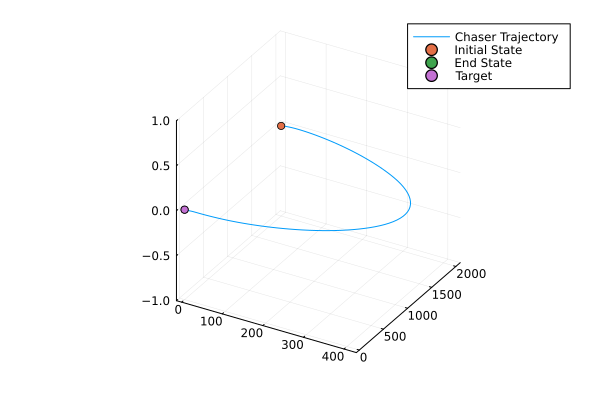

In [57]:
plot(xhist_si[1,:], xhist_si[2,:], xhist_si[3,:], label = "Chaser Trajectory", zlim = (-1,1))

scatter!([xhist_si[1,1]], [xhist_si[2,1]], [xhist_si[3,1]], label = "Initial State")
scatter!([xhist_si[1,end]], [xhist_si[2,end]], [xhist_si[3,end]], label = "End State")

scatter!([0], [0], [0], label= "Target")

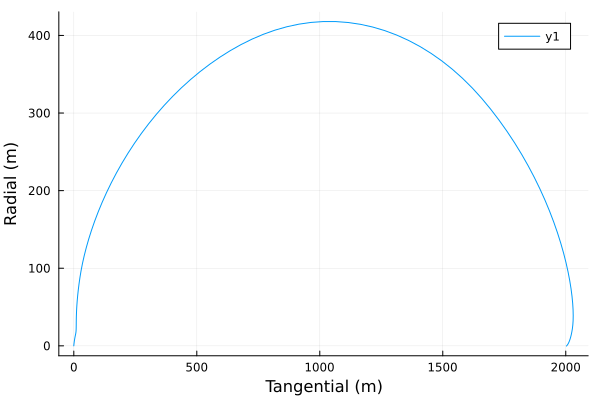

In [58]:
plot(xhist_si[2,:], xhist_si[1,:], xlabel= "Tangential (m)", ylabel="Radial (m)")

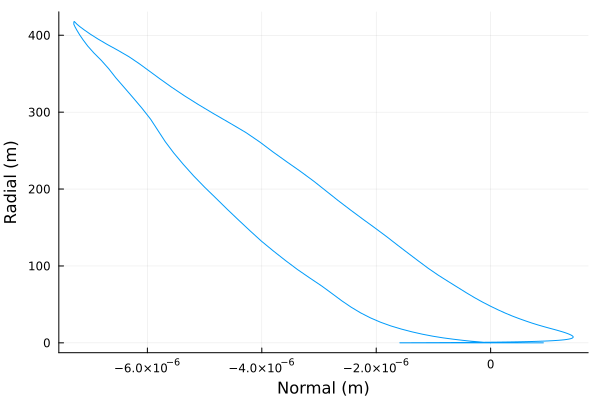

In [59]:
plot(xhist_si[3,:], xhist_si[1,:], xlabel= "Normal (m)", ylabel="Radial (m)", label=false)

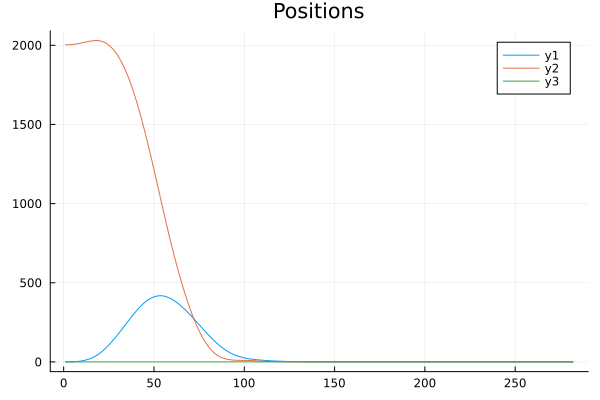

In [60]:
plot(xhist_si[1,:], title="Positions") 
plot!(xhist_si[2,:])
plot!(xhist_si[3,:])

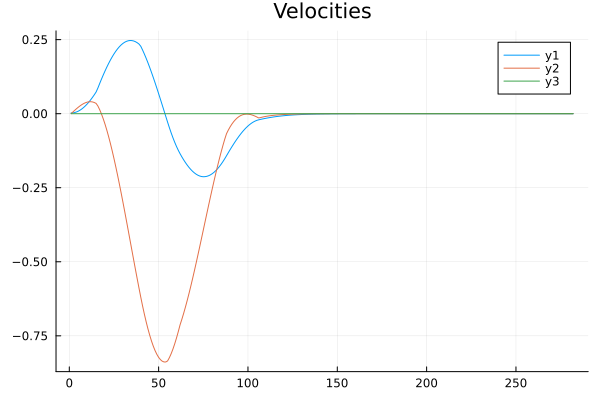

In [61]:
plot(xhist_si[4,:], title="Velocities") 
plot!(xhist_si[5,:])
plot!(xhist_si[6,:])

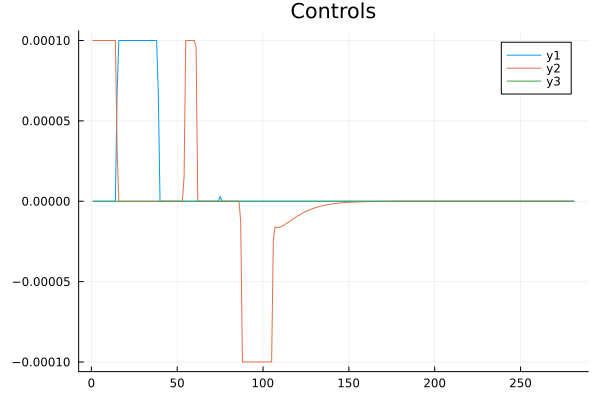

In [62]:
plot(uhist_si[1,:], title = "Controls")
plot!(uhist_si[2,:])
plot!(uhist_si[3,:])

In [63]:
fuel_usage_accel = sum(abs.(vec(uhist_si)))

0.006713407910255259

In [64]:
delta_v = dt*fuel_usage_accel 

0.40280447461531554

In [65]:
no_control = zeros(nx, iterations)

6×282 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [66]:
no_control[:,1] = x0_chaser

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [67]:
for i = 1:iterations-1

    no_control[:, i+1] = Ad*no_control[:,i]

end

In [68]:
# plot(no_control[1,:], no_control[2,:], no_control[3,:], zlims=(-1,1))
# scatter!([0], [0], [0])

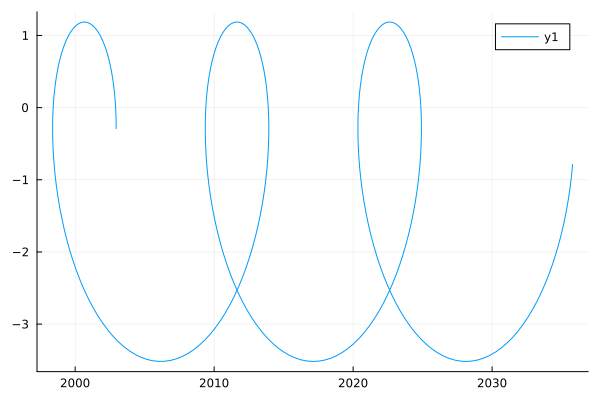

In [69]:
plot(no_control[2,:], no_control[1,:])

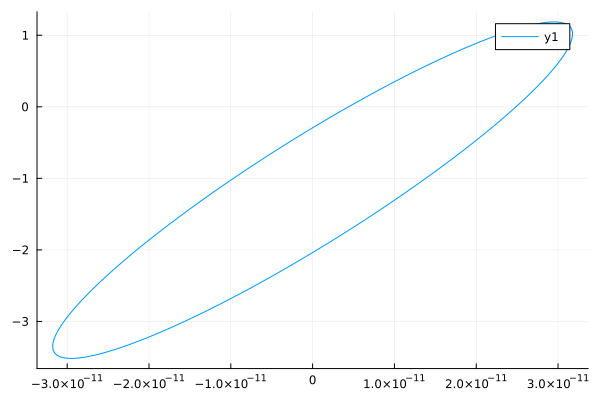

In [70]:
plot(no_control[3,:], no_control[1,:])